In [1]:
import tensorflow as tf
import numpy as np
#import mnist_handler
import os
import pandas as pd
import matplotlib.pyplot as plt
#os.environ["CUDA_VISIBLE_DEVICES"]="3"; 
INPUT_DIMENSION = 36
NUM_CLASSES = 6

train_dataset = np.array(pd.read_csv("Satimage_dataset/sat_trn.csv",header = None, delimiter=' '))
test_dataset = np.array(pd.read_csv("Satimage_dataset/sat_tst.csv",header = None, delimiter=' '))

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print(train_dataset)
print(train_dataset.shape)
print(test_dataset)
print(test_dataset.shape)

[[ 92 115 120 ... 113  87   3]
 [ 84 102 106 ... 104  79   3]
 [ 84 102 102 ... 104  79   3]
 ...
 [ 68  75 108 ... 104  85   4]
 [ 71  87 108 ... 104  85   4]
 [ 71  91 100 ... 100  81   4]]
(4435, 37)
[[ 80 102 102 ... 113  87   3]
 [ 76 102 102 ... 104  83   3]
 [ 80  98 106 ...  96  75   4]
 ...
 [ 56  68  91 ...  92  74   5]
 [ 56  68  87 ...  92  70   5]
 [ 60  71  91 ... 108  92   5]]
(2000, 37)


In [3]:
y_train = train_dataset[:,36] -1
y_test = test_dataset[:,36]-1
x_train = train_dataset[:,0:36]
x_test = test_dataset[:,0:36]
print(y_test.shape)
y_train = np.where(y_train < 6, y_train, 5)
y_test = np.where(y_test < 6, y_test, 5)
print(np.unique(y_train))

(2000,)
[0 1 2 3 4 5]


In [4]:
total = np.concatenate((x_train,x_test),axis = 0)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(total)
total = scaler.transform(total)
total.shape

/usr/lib/python3/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(6435, 36)

In [27]:
x_train = total[0:4435]
#y_train = total[0:38,0]
y_train = np.array(y_train, dtype=np.int16)
x_test = total[4435:]
#y_test = total[38:,0]
y_test = np.array(y_test, dtype=np.int16)
print(x_train.shape)
print(x_test.shape)
print(y_train)
print(y_test.shape)

(4435, 36)
(2000, 36)
[2 2 2 ... 3 3 3]
(2000,)


In [28]:
np.savetxt("xt_train.csv", x_train, delimiter=",")
np.savetxt("yt_train.csv", y_train, delimiter=",")
np.savetxt("xt_test.csv", x_test, delimiter=",")
np.savetxt("yt_test.csv", y_test, delimiter=",")

In [6]:
p = np.random.permutation(len(x_train))
x_train = x_train[p]
y_train = y_train[p]
x_train.shape
y_train

array([0, 2, 3, ..., 2, 3, 2], dtype=int16)

In [7]:
from auto_elm import AUTO_ELM   # Our proposed algorithm
n_input_nodes = 36
n_hidden_nodes = 26  # used to be 256
n_output_nodes = 36

In [8]:
border = 435
x_train_init = x_train[:border]
x_train_seq = x_train[border:]

In [9]:
import time
accuracy_sum = 0
time_sum = 0
for PPAP in range(10):
	tf.reset_default_graph()
	# ===========================================
	# Instantiate os-elm
	# ===========================================
	auto_elm = AUTO_ELM(
		# the number of input nodes.
		n_input_nodes=n_input_nodes,
		# the number of hidden nodes.
		n_hidden_nodes=n_hidden_nodes,
		# the number of output nodes.
		n_output_nodes=n_output_nodes,
		# loss function.
		# the default value is 'mean_squared_error'.
		# for the other functions, we support
		# 'mean_absolute_error', 'categorical_crossentropy', and 'binary_crossentropy'.
		c_value = 2.0**(-1),
		loss='mean_squared_error',
		# activation function applied to the hidden nodes.
		# the default value is 'sigmoid'.
		# for the other functions, we support 'linear' and 'tanh'.
		# NOTE: OS-ELM can apply an activation function only to the hidden nodes.
		activation='sin',
	)
	# ===========================================
	# Training
	# ===========================================
	# the initial training phase
	t1 = time.time()
	auto_elm.init_train(x_train_init, x_train_init)
	t2 = time.time()
	time_sum+=(t2-t1)

	# the sequential training phase
	batch_size = 1000

	t1 = time.time()
	for epoch in range(100):
		for i in range(0, len(x_train_seq), batch_size):
			x_batch = x_train_seq[i:i+batch_size]
			if len(x_batch) != batch_size:
				break
			auto_elm.seq_train(x_batch, x_batch)
	t2 = time.time()
	time_sum+=(t2-t1)/100

In [10]:
x_train_encoded = auto_elm.encoding(x_train)
x_test_encoded = auto_elm.encoding(x_test)
x_train_encoded.shape

(4435, 26)

In [11]:

border = 435
x_train_init = x_train_encoded[:border]
y_train_init = y_train[:border]
x_train_seq = x_train_encoded[border:]
y_train_seq = y_train[border:]
INPUT_DIMENSION = 26
NUM_CLASSES = 6

In [12]:
tf.reset_default_graph() # clear all the tensors
sess = tf.Session()


"""Placeholders"""
X_ = tf.placeholder(tf.float32, [None, INPUT_DIMENSION])
#X_ = tf.reshape(X, [-1, INPUT_DIMENSION]) # Flatten X: [N,D]
Y = tf.placeholder(tf.int64, [None]) # labels
Y_ = tf.one_hot(indices=Y, depth=NUM_CLASSES) # one_hot labels: [N,M]

"""Some constants"""
D = INPUT_DIMENSION
M = NUM_CLASSES # Number of outputs
C = tf.constant(2.0**(2))

"""Weights"""
alpha_1 = tf.get_variable('alpha_1',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 1st subnetwork
alpha_2 = tf.get_variable('alpha_2',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 2st subnetwork
alpha_3 = tf.get_variable('alpha_3',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_1 = tf.get_variable('beta_1',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_2 = tf.get_variable('beta_2',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_3 = tf.get_variable('beta_3',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)

In [13]:
k = tf.get_variable('k',shape=[D, D],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
m = tf.get_variable('m',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)

In [14]:
"""Utility functions"""
def mul(A, B):
    return tf.matmul(A, B)

def inv(A):
    return tf.matrix_inverse(A)

def t(A):
    return tf.transpose(A)

def sin(A):
    return tf.math.sin(A)

def asin(A):
    return tf.math.asin(A)

def sqrt(A):
    return tf.sqrt(A)

def sqr(A):
    return tf.math.pow(A, 2)

def pseudo_inv(A, I, C):
    C_I = I/C
    return mul(t(A), inv(C_I + mul(A, t(A))))

def h(A):
    '''activation function'''
    return sin(A)

def h_(A):
    '''inverse activation function'''
    return asin(A)

def u(A):
    '''normalize the input to (0,1]'''
    return tf.math.sigmoid(A) # sigmoid
    
def u_(A):
    '''the inverse of u'''
    ONE = tf.constant(1.0)
    return -(tf.math.log(ONE/A - ONE)) # the inverse of sigmoid
    
def subnet_output(alpha, beta, A):
    return t(mul(beta, h(mul(t(alpha), t(A))))) 

# Initial Training

In [15]:
"""Initial Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)
'''some pre-computations'''
X_init = t(X_) # [D,N]
Y_init = t(Y_) # [M,N]
N_init = D # number of dimensions
I_DxD = tf.eye(N_init, dtype=tf.float32) # [D,D]
I_MxM = tf.eye(M, dtype=tf.float32) # [M,M]
C_I = I_DxD/C
H_I = I_MxM/C

add = C_I + mul(X_init, t(X_init))
k = tf.assign(k,add)
X_inv_init = pseudo_inv(X_init, I_DxD, C) # [N,D]

'''1st subnet'''
alpha_1_init_calculated = t(mul(h_(Y_init), X_inv_init)) # ([M,N]x[N,D])T=[D,M]
alpha_1_init = tf.assign(alpha_1, alpha_1_init_calculated) # [D,M]
H_1_init = h(mul(t(alpha_1_init), X_init)) # [M,N]
H_add = H_I + mul(H_1_init,t(H_1_init))
m = tf.assign(m,H_add)
H_pseudo_init = pseudo_inv(H_1_init,I_MxM,C) #[N,M]

beta_1_init_calculated = mul(Y_init, t(H_1_init))/sqr(tf.norm(H_1_init)) # [M,M]
beta_1_init_calculated = mul(Y_init,H_pseudo_init)

beta_1_init = tf.assign(beta_1, beta_1_init_calculated) # [M,M]
H_beta_1_init = mul(beta_1_init, t(mul(t(X_init), alpha_1_init))) # [M,N]
E_1_init = Y_init - H_beta_1_init # [M,N]

'''2nd subnet'''
#alpha_2_init_calculated = t(mul(h_(E_1_init), X_inv_init)) # [D,M]    
alpha_2_init_calculated = t(mul(asin(Y_init), X_inv_init)) # [D,M]

alpha_2_init = tf.assign(alpha_2, alpha_2_init_calculated) # [D,M]
H_2_init = h(mul(t(alpha_2_init), X_init)) # [M,N]
H_2_inv_init = pseudo_inv(H_2_init, I_MxM, C) # [M,N]
H_add = H_I + mul(H_2_init,t(H_2_init))
#m = tf.assign(m,H_add)
H_pseudo_init = pseudo_inv(H_2_init,I_MxM,C) #[N,M]

beta_2_init_calculated = mul(E_1_init, t(H_2_init))/sqr(tf.norm(H_2_init)) # [M,M]
beta_2_init_calculated = mul(E_1_init, H_pseudo_init)

beta_2_init = tf.assign(beta_2, beta_2_init_calculated) # [M,M]
H_beta_2_init = mul(beta_2_init, t(mul(t(X_init), alpha_2_init))) # [M,N]
E_2_init = Y_init - (H_beta_1_init+H_beta_2_init) # [M,N]

'''3rd subnetwork'''
alpha_3_init_calculated = t(mul(h_(E_2_init), X_inv_init)) # [D,M]    
alpha_3_init_calculated = t(mul(asin(Y_init), X_inv_init)) # [D,M]

alpha_3_init = tf.assign(alpha_3, alpha_3_init_calculated) # [D,M]
H_3_init = h(mul(t(alpha_3_init), X_init)) # [M,N]
H_3_inv_init = pseudo_inv(H_3_init, I_MxM, C) # [M,N]

beta_3_init_calculated = mul(E_2_init, t(H_3_init))/sqr(tf.norm(H_3_init)) # [M,M]
beta_3_init_calculated = mul(E_2_init, H_3_inv_init)

beta_3_init = tf.assign(beta_3, beta_3_init_calculated) # [M,M]
H_beta_3_init = mul(beta_3_init, t(mul(t(X_init), alpha_3_init))) # [M,N]
E_3_init = Y_init - (H_beta_3_init+H_beta_2_init+ H_beta_1_init) # [M,N]

#init_train_graph = H_beta_1_init
init_train_graph = E_3_init



In [16]:
beta_1_init

<tf.Tensor 'Assign_3:0' shape=(6, 6) dtype=float32_ref>

In [17]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [18]:

'''With one subnetwork'''
logits_init = subnet_output(alpha_1, beta_1, X_) 
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [19]:
"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [20]:
"""Initial training"""
sess.run(E_1_init, feed_dict={X_: x_train_init, Y: y_train_init})
print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_train_encoded, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_test_encoded, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial training done
Initial train training loss:  0.05898908
Initial train training accuracy:  0.79932356
Initial train testing loss:  0.06214746
Initial train testing accuracy:  0.774


In [21]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) 
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [22]:
"""Initial training"""
sess.run(E_2_init, feed_dict={X_: x_train_init, Y: y_train_init})
print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_train_encoded, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_test_encoded, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial training done
Initial train training loss:  0.07292233
Initial train training accuracy:  0.8045096
Initial train testing loss:  0.075550616
Initial train testing accuracy:  0.7865


In [23]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [24]:
"""Initial training"""
sess.run(init_train_graph, feed_dict={X_: x_train_init, Y: y_train_init})
print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_train_encoded, Y: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_test_encoded, Y: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial training done
Initial train training loss:  0.06291959
Initial train training accuracy:  0.8063134
Initial train testing loss:  0.065684386
Initial train testing accuracy:  0.7825


In [25]:
logits_init = subnet_output(alpha_1, beta_1, X_)+ subnet_output(alpha_2, beta_2, X_)

In [26]:
logic = sess.run(logits_init, feed_dict={X_ : [x_test_encoded[4]]})
print(np.argmax(logic,axis =1))
print(y_test[4])
#plt.imshow(x_test[4200])

[5]
3


In [27]:
logic = sess.run(logits_init, feed_dict={X_ : [x_test_encoded[40]]})
print(np.argmax(logic,axis =1))
print(y_test[40])
#plt.imshow(x_test[4000])

[5]
3


# Sequential Training

In [28]:
"""Sequential Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)
X_seq = t(X_) # [D,N]
Y_seq = t(Y_) # [M,N]
pseudo = mul(X_seq, X_) #DXD
k = tf.assign(k, tf.add(k,pseudo)) #DXD
k_inv = inv(k)

new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_1))
alpha1_seq = tf.assign(alpha_1,tf.add(alpha_1,new)) #DXM
H_1_seq = h(mul(t(alpha1_seq), X_seq)) # [M,N]
m_su = mul(H_1_seq,t(H_1_seq))
m = tf.assign(m,tf.add(m,m_su))
m_inv = inv(m)
#update = tf.matmul(tf.matmul(m_inv,H_1_seq),h_(Y_seq)- tf.matmul())
H_pseudo_init = pseudo_inv(H_1_seq,I_MxM,C) #[N,M]
#UPDATE = tf.matmul(tf.matmul(K_inverse, HT), inverse_acti_y - tf.matmul(H, self.__outputWeight))
beta_1_seq_calculated = mul(Y_seq, H_pseudo_init) # [M,M]
beta_1_seq = tf.assign(beta_1, beta_1_seq_calculated) # [M,M]
H_beta_1_seq = mul(beta_1_seq, t(mul(X_, alpha1_seq))) # [M,N]
E_1_seq = Y_seq - H_beta_1_seq # [M,N]

'''2nd subnetwork'''

new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_2))
alpha2_seq = tf.assign(alpha_2,tf.add(alpha_2,new)) #DXM
H_2_seq = h(mul(t(alpha2_seq), X_seq)) # [M,N]
H_pseudo_init = pseudo_inv(H_2_seq,I_MxM,C) #[N,M]
beta_2_seq_calculated = mul(E_1_seq, H_pseudo_init) # [M,M]
beta_2_seq = tf.assign(beta_2, beta_2_seq_calculated) # [M,M]
H_beta_2_seq = mul(beta_2_seq, t(mul(t(X_seq), alpha2_seq))) # [M,N]
E_2_seq = Y_seq - (H_beta_2_seq+ H_beta_1_seq) # [M,N]

'''3rd subnetwork'''
new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_3))
alpha3_seq = tf.assign(alpha_3,tf.add(alpha_3,new)) #DXM
H_3_seq = h(mul(t(alpha3_seq), X_seq)) # [M,N]
H_pseudo_init = pseudo_inv(H_3_seq,I_MxM,C) #[N,M]
beta_3_seq_calculated = mul(E_2_seq, H_pseudo_init) # [M,M]
beta_3_seq = tf.assign(beta_3, beta_3_seq_calculated) # [M,M]
H_beta_3_seq = mul(beta_3_seq, t(mul(t(X_seq), alpha3_seq))) # [M,N]
E_3_seq = Y_seq - (H_beta_3_seq +H_beta_2_seq + H_beta_1_seq )# [M,N]
seq_train_graph = E_3_seq




In [29]:
"""Evaluate initial-training graph"""
logits_seq =  subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

In [30]:
"""Sequential training"""
batch_size = 1000

epoch_train_accuracy = []
epoch_test_accuracy = []
for epoch in range(20):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(seq_train_graph, feed_dict={X_: x_batch, Y: y_batch})
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_train_encoded, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_test_encoded, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")

"""Sequential training evaluation"""
#tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_train, Y: y_train})
#ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_test, Y: y_test})
#print("Sequential train training loss: ", tr_loss)
#print("Sequential train training accuracy: ", tr_acc)
#print("Sequential train testing loss: ", ts_loss)
#print("Sequential train testing accuracy: ", ts_acc)

train_loss: 0.058828, train_accuracy: 0.823901
test_loss: 0.061913, test_accuracy: 0.798000
train_loss: 0.058064, train_accuracy: 0.827283
test_loss: 0.061161, test_accuracy: 0.803000
train_loss: 0.057730, train_accuracy: 0.829312
test_loss: 0.060803, test_accuracy: 0.805000
train_loss: 0.057547, train_accuracy: 0.830440
test_loss: 0.060596, test_accuracy: 0.806500
train_loss: 0.057433, train_accuracy: 0.831567
test_loss: 0.060460, test_accuracy: 0.809000
train_loss: 0.057354, train_accuracy: 0.831342
test_loss: 0.060364, test_accuracy: 0.809000
train_loss: 0.057296, train_accuracy: 0.831342
test_loss: 0.060293, test_accuracy: 0.808500
train_loss: 0.057250, train_accuracy: 0.831116
test_loss: 0.060237, test_accuracy: 0.810000
train_loss: 0.057213, train_accuracy: 0.832018
test_loss: 0.060192, test_accuracy: 0.811000
train_loss: 0.057182, train_accuracy: 0.832018
test_loss: 0.060155, test_accuracy: 0.811000
train_loss: 0.057155, train_accuracy: 0.832244
test_loss: 0.060123, test_accurac

'Sequential training evaluation'

In [31]:
logits_seq =  subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) 
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [32]:
"""Sequential training"""
batch_size = 2000

epoch_train_accuracy = []
epoch_test_accuracy = []
for epoch in range(27):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(E_2_seq, feed_dict={X_: x_batch, Y: y_batch})
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_train_encoded, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_test_encoded, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")

"""Sequential training evaluation"""

train_loss: 0.070411, train_accuracy: 0.829538
test_loss: 0.072614, test_accuracy: 0.813000
train_loss: 0.070360, train_accuracy: 0.829087
test_loss: 0.072553, test_accuracy: 0.812500
train_loss: 0.070339, train_accuracy: 0.829087
test_loss: 0.072527, test_accuracy: 0.812500
train_loss: 0.070326, train_accuracy: 0.829312
test_loss: 0.072511, test_accuracy: 0.812000
train_loss: 0.070317, train_accuracy: 0.829312
test_loss: 0.072500, test_accuracy: 0.812000
train_loss: 0.070309, train_accuracy: 0.829312
test_loss: 0.072490, test_accuracy: 0.812000
train_loss: 0.070302, train_accuracy: 0.829312
test_loss: 0.072481, test_accuracy: 0.812000
train_loss: 0.070296, train_accuracy: 0.829312
test_loss: 0.072473, test_accuracy: 0.812500
train_loss: 0.070290, train_accuracy: 0.829763
test_loss: 0.072465, test_accuracy: 0.812500
train_loss: 0.070284, train_accuracy: 0.829989
test_loss: 0.072458, test_accuracy: 0.812500
train_loss: 0.070279, train_accuracy: 0.830440
test_loss: 0.072451, test_accurac

'Sequential training evaluation'

In [33]:
"""Evaluate initial-training graph"""
logits_seq =  subnet_output(alpha_1, beta_1, X_) 
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

In [34]:
"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [35]:
"""Sequential training"""
batch_size = 1000

epoch_train_accuracy = []
epoch_test_accuracy = []
for epoch in range(10):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    t1 = time.time()
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(E_1_seq, feed_dict={X_: x_batch, Y: y_batch})
        t2 = time.time()
        time_sum+=(t2-t1)
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_train_encoded, Y: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_test_encoded, Y: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")
print("time",time_sum/10)

"""Sequential training evaluation"""

train_loss: 0.054168, train_accuracy: 0.827057
test_loss: 0.057991, test_accuracy: 0.799500
train_loss: 0.053006, train_accuracy: 0.828185
test_loss: 0.056789, test_accuracy: 0.799500
train_loss: 0.052609, train_accuracy: 0.829312
test_loss: 0.056351, test_accuracy: 0.801500
train_loss: 0.052380, train_accuracy: 0.829538
test_loss: 0.056078, test_accuracy: 0.803500
train_loss: 0.052235, train_accuracy: 0.829312
test_loss: 0.055897, test_accuracy: 0.805000
train_loss: 0.052135, train_accuracy: 0.829763
test_loss: 0.055770, test_accuracy: 0.805000
train_loss: 0.052062, train_accuracy: 0.830214
test_loss: 0.055675, test_accuracy: 0.805000
train_loss: 0.052005, train_accuracy: 0.830214
test_loss: 0.055602, test_accuracy: 0.805500
train_loss: 0.051958, train_accuracy: 0.830214
test_loss: 0.055544, test_accuracy: 0.805500
train_loss: 0.051920, train_accuracy: 0.830214
test_loss: 0.055496, test_accuracy: 0.805000
Sequential training done
time 0.09799307513236999


'Sequential training evaluation'

[[ 0.08985694 -0.02696724  0.34058443  0.32188323  0.00984284  0.36406624]]
5
3


TypeError: Invalid dimensions for image data

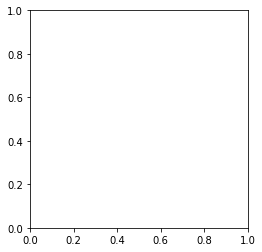

In [36]:
logits_ = subnet_output(alpha_1, beta_1, X_) 
logits__ = sess.run(logits_, feed_dict={X_: [x_test_encoded[4]]})
print(logits__)
print(np.argmax(logits__))
print(y_test[4])
plt.imshow(x_test[4])

In [ ]:
def visualize_alpha(alpha, size):
    tmp = sess.run(alpha)
    plt.figure(figsize=(10,4))
    for i in range(2):
        for j in range(5):
            plt.subplot(2,5,i*5+j+1)
            plt.imshow(np.reshape(tmp[:,i*5+j], [size,size]))

def visualize_beta(beta):
    tmp = sess.run(beta)
    plt.figure(figsize=(4,4))
    plt.imshow(tmp)
    
            
"""visualize subnet nodes"""            
visualize_alpha(alpha_1, 28)
visualize_beta(beta_1)
visualize_alpha(alpha_2, 28)
visualize_beta(beta_2)

# ML-elm check

In [13]:
def one_hot(y, classes):
    I = np.eye(classes)
    #print(I)
    ret = []
    l = 0
    for y_ in y:
        ret.append(I[y_])
            
    return np.array(ret)
    
y_train_onehot = one_hot(y_train, 6)
y_test_onehot = one_hot(y_test,6)

In [20]:
input_size = 36
output_size = 6 # mnist has 10 output classes 

In [21]:
x_train.shape

(4435, 36)

In [22]:
from ml_elm import ML_ELM

mlelm1 = ML_ELM(input_size=input_size, output_size=output_size, name='mlelm1')

In [23]:
mlelm1.add_layer(n_neurons=101, l2norm=1e2); 


In [24]:
mlelm1.add_layer(n_neurons=101, activation=tf.tanh, l2norm=1e2); 

In [25]:
mlelm1.fit(x_train,y_train_onehot, batch_size=500)

2019-05-15 10:50:30.032584 ML-ELM Start training...
AE Network parameters have been initialized
Training AE 1/1
2019-05-15 10:50:30.274589 Start training...
Training of AE mlelm1 ended in 0:0:0.436110
Evaluating AE performance...
MSE: 0.0009952
####################################################################################################
Initializing last layer ELM...
Training last layer ELM...
Training of ELM mlelm1 ended in 0:0:0.044637
####################################################################################################
####################################################################################################
TOTAL Training of ML_ELM mlelm1 ended in 0:0:0.838812
####################################################################################################
Evaluating network performance
Accuracy: 0.7525032


0.75250316

In [26]:
mlelm1.evaluate(x_test, y_test_onehot, batch_size=500)

Evaluating network performance
Accuracy: 0.7320000


0.732